In [1]:
# initial setup
%run "../../../common/0_notebooks_base_setup.py"


/Users/csuarezgurruchaga/Desktop/Digital-House/CLASE_38/dsad_2021/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
Running command `conda install --yes nltk=3.5.0`... ok
Solving environment: ...working... done

# All requested packages already installed.


unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


**Setup**

Si la instalación de lightgbm da error, ejecutar en Anaconda Prompt 

`conda install -c conda-forge xgboost=1.4.0`

`conda install -c conda-forge lightgbm=3.2.1`

---

<img src='../../../common/logo_DH.png' align='left' width=35%/>


## Prediciendo quiebra de empresas - parte II

Continuando con el ejercicio del Checkpoint, usaremos ahora otros modelos de Boosting:
- LightGBM
- Catboost

Ya hemos visto que XGBoost es una implementación de Gradient Boosting que busca mejorar su performance, y esto lo hace  mediante la aplicación de métodos de regularización para evitar sobreajustes.  

A continuación veremos otros dos implementaciones de Gradient Boosting que también buscan mejorar su performance cada uno con sus propias técnicas, pero principalmente trabajando sobre las técnicas de split.

Cada uno de estos modelos tienen sus pros y cons. En este [link](https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc) encontraremos una comparación detallada de cada uno de ellos.


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st

In [3]:
df = pd.read_csv("../Data/3year.csv")

In [4]:
df.head()

,Unnamed: 0,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,b'0'
1,1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,b'0'
2,2,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,b'0'
3,3,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,...,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,b'0'
4,4,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,b'0'


In [5]:
# eliminamos la primera columna que se trata de un indice.
df = df.drop("Unnamed: 0", axis = 1)

Acá hay una descripción de los atributos

- Attr1: net profit / total assets
- Attr2: total liabilities / total assets
- Attr3: working capital / total assets
- Attr4: current assets / short-term liabilities
- Attr5: [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365
- Attr6: retained earnings / total assets
- Attr7: EBIT / total assets
- Attr8: book value of equity / total liabilities
- Attr9: sales / total assets
- Attr10: equity / total assets
- Attr11: (gross profit + extraordinary items + financial expenses) / total assets
- Attr12: gross profit / short-term liabilities
- Attr13: (gross profit + depreciation) / sales
- Attr14: (gross profit + interest) / total assets
- Attr15: (total liabilities * 365) / (gross profit + depreciation)
- Attr16: (gross profit + depreciation) / total liabilities
- Attr17: total assets / total liabilities
- Attr18: gross profit / total assets
- Attr19: gross profit / sales
- Attr20: (inventory * 365) / sales
- Attr21: sales (n) / sales (n-1)
- Attr22: profit on operating activities / total assets
- Attr23: net profit / sales
- Attr24: gross profit (in 3 years) / total assets
- Attr25: (equity - share capital) / total assets
- Attr26: (net profit + depreciation) / total liabilities
- Attr27: profit on operating activities / financial expenses
- Attr28: working capital / fixed assets
- Attr29: logarithm of total assets
- Attr30: (total liabilities - cash) / sales
- Attr31: (gross profit + interest) / sales
- Attr32: (current liabilities * 365) / cost of products sold
- Attr33: operating expenses / short-term liabilities
- Attr34: operating expenses / total liabilities
- Attr35: profit on sales / total assets
- Attr36: total sales / total assets
- Attr37: (current assets - inventories) / long-term liabilities
- Attr38: constant capital / total assets
- Attr39: profit on sales / sales
- Attr40: (current assets - inventory - receivables) / short-term liabilities
- Attr41: total liabilities / ((profit on operating activities + depreciation) * (12/365))
- Attr42: profit on operating activities / sales
- Attr43: rotation receivables + inventory turnover in days
- Attr44: (receivables * 365) / sales
- Attr45: net profit / inventory
- Attr46: (current assets - inventory) / short-term liabilities
- Attr47: (inventory * 365) / cost of products sold
- Attr48: EBITDA (profit on operating activities - depreciation) / total assets
- Attr49: EBITDA (profit on operating activities - depreciation) / sales
- Attr50: current assets / total liabilities
- Attr51: short-term liabilities / total assets
- Attr52: (short-term liabilities * 365) / cost of products sold)
- Attr53: equity / fixed assets
- Attr54: constant capital / fixed assets
- Attr55: working capital
- Attr56: (sales - cost of products sold) / sales
- Attr57: (current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)
- Attr58: total costs /total sales
- Attr59: long-term liabilities / equity
- Attr60: sales / inventory
- Attr61: sales / receivables
- Attr62: (short-term liabilities *365) / sales
- Attr63: sales / short-term liabilities
- Attr64: sales / fixed assets
- class: toma los valores "b'0'" y "b'1'" indicando si la empresa quebro o no.

### Ejercicio 1
1) Obtener la `matriz de features X` y la `variable target y`  
2) Analizar la forma (shape) del dataset.  
3) Ver los valores que toma la variable target  
4) Aplicar LabelEncoder sobre la variable target.

In [6]:
y = df["class"]
X = df.drop("class", axis = 1)

In [7]:
print("el dataset tiene ", X.shape[0], " filas y ", X.shape[1], " columnas")

el dataset tiene  10503  filas y  64  columnas


In [8]:
y.unique()

array(["b'0'", "b'1'"], dtype=object)

In [9]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [10]:
y = encoder.fit_transform(y)

In [11]:
y

array([0, 0, 0, ..., 1, 1, 1])

### Ejercicio 2
1) Realizar un split en Train y Test, dejando un 20% para test  
2) crear un generador de CV utilizando: `cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)` para luego pasarselo tanto a `GridSearchCV` como a `cross_val_score`


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [13]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

### Ejercicio 3: LightGBM
1) Importar el clasificador `LGBMClassifier()` de la libreria `lightgbm`.

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier

La lista completa de hiperparámetros se puede consultar [aquí](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst)

In [14]:
import lightgbm as lgb
model_lgb = lgb.LGBMClassifier()

2) Utilizando el siguiente diccionario de parametros, optimizar los hiperparámetros.  
3) Imprimir en pantalla la mejor selección de hiperparámetros

In [15]:
from sklearn.model_selection import GridSearchCV
params = {  
    "n_estimators": [50,100,500],      # Number of boosted trees to fit.
    "max_depth": [1,2,3,4],            # Maximum tree depth for base learners.
    "learning_rate": [0.01, 0.1],      # Boosting learning rate (xgb’s “eta”)
}

In [16]:
grid_lgb = GridSearchCV(model_lgb, param_grid=params, cv=cv, verbose=1, n_jobs=-1)

In [17]:
grid_lgb.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   10.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [1, 2, 3, 4],
                         'n_estimators': [50, 100, 500]},
             verbose=1)

In [18]:
grid_lgb.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}

5) Evaluar el rendimiento del estimador optimo, utilizando cross validation.  
(pasarle como argumento cv el generador de CV splits del creado en el punto 3)  
**nota:** ver función evaluar_rendimiento() utilizada en la notebook `2-Boosting_Practica.ipynb`

In [19]:
def evaluar_rendimiento(modelo, nombre, X, y, cv):
    s = cross_val_score(modelo, X, y, cv=cv, n_jobs=-1)
    print("Rendimiento de {}:\t{:0.3} ± {:0.3}".format( \
        nombre, s.mean().round(3), s.std().round(3)))

In [20]:
evaluar_rendimiento(grid_lgb.best_estimator_,"Light GBM", X_train, y_train, cv)


Rendimiento de Light GBM:	0.972 ± 0.004


6) utilizando roc_auc_score de la libreria sklearn.metrics, determinar el valor del ROC.

In [21]:
from sklearn.metrics import roc_auc_score
lgbm_auc = roc_auc_score(y_test,grid_lgb.predict(X_test))
print("El valor del AUC es: ", lgbm_auc)

El valor del AUC es:  0.7178709024269069


7) utilizando plot_roc de la libreria sklearn.metrics, graficamos la curva ROC por clase

In [22]:
from scikitplot.metrics import plot_roc
plot_roc(y_test,grid_lgb.predict_proba(X_test), plot_micro = False, plot_macro= False);

### BONUS: 
graficar la importancia de los atributos del estimador optimizado.  
**nota:** LightGBM tiene un método propio para graficar`plot_importance` 

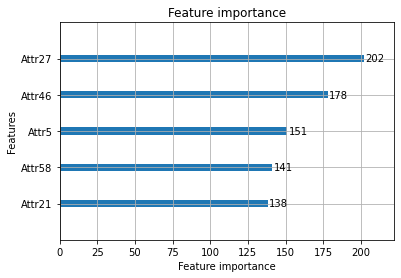

In [30]:
%matplotlib inline
lgb.plot_importance(grid_lgb.best_estimator_, max_num_features=5);

### Ejercicio 4: Catboost
1) Importar el clasificador `CatBoostClassifier()` de la libreria `catboost`.

https://catboost.ai/docs/concepts/about.html

In [24]:
from catboost import CatBoostClassifier
model_cat = CatBoostClassifier()

2) Con catboost los resultados sin optimizar hiperparámetros ya son excelentes. Procedemos a entrenar el modelo con los datos de training.

In [25]:
model_cat.fit(X_train, y_train)

Learning rate set to 0.025565
0:	learn: 0.6557483	total: 70ms	remaining: 1m 9s
1:	learn: 0.6218370	total: 75.1ms	remaining: 37.5s
2:	learn: 0.5879991	total: 79.8ms	remaining: 26.5s
3:	learn: 0.5584336	total: 85.6ms	remaining: 21.3s
4:	learn: 0.5308600	total: 90.7ms	remaining: 18.1s
5:	learn: 0.5048666	total: 95.6ms	remaining: 15.8s
6:	learn: 0.4779885	total: 102ms	remaining: 14.4s
7:	learn: 0.4535446	total: 107ms	remaining: 13.3s
8:	learn: 0.4323359	total: 112ms	remaining: 12.3s
9:	learn: 0.4137795	total: 118ms	remaining: 11.7s
10:	learn: 0.3915143	total: 123ms	remaining: 11.1s
11:	learn: 0.3756562	total: 128ms	remaining: 10.5s
12:	learn: 0.3613375	total: 133ms	remaining: 10.1s
13:	learn: 0.3478718	total: 138ms	remaining: 9.73s
14:	learn: 0.3328657	total: 143ms	remaining: 9.41s
15:	learn: 0.3215088	total: 149ms	remaining: 9.15s
16:	learn: 0.3111977	total: 154ms	remaining: 8.89s
17:	learn: 0.3008223	total: 158ms	remaining: 8.64s
18:	learn: 0.2922915	total: 164ms	remaining: 8.45s
19:	lea

3) Una vez entrenado el modelo, realizar las predicciones sobre el dataset de prueba. 

In [26]:
y_predicted_cat = model_cat.predict(X_test)
y_predicted_cat.shape

(2101,)

4) utilizando roc_auc_score de la libreria sklearn.metrics, determinar el valor del ROC.

In [27]:
cat_auc = roc_auc_score(y_test,y_predicted_cat)
print("El valor del AUC es: ", cat_auc)

El valor del AUC es:  0.7051059721219733


5) utilizando plot_roc de la libreria sklearn.metrics, graficamos la curva ROC por clase

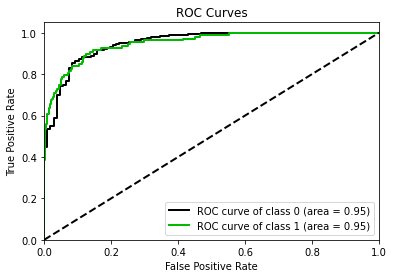

In [28]:
from scikitplot.metrics import plot_roc
plot_roc(y_test,model_cat.predict_proba(X_test), plot_micro = False, plot_macro= False);